In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import cmb_anomaly_utils as cau

#### Run Parameters

In [4]:
max_sim_num                     = 1000
base_path                       = "./output/"
run_inputs  = cau.run_utils.RunInputs()
run_inputs.mask_fpath           = "./input/cmb_fits_files/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
run_inputs.cmb_fpath            = "./input/cmb_fits_files/COM_CMB_IQU-commander_2048_R3.00_full.fits"
run_inputs.cmb_dir_anom_fpath   = "./output/cmb_inpainted_all_dir_cap_anom.txt"
run_inputs.sims_path            = "./input/commander_sims/"
run_inputs.noise_path           = "./input/commander_noise/"
run_inputs.sims_dir_anom_path   = "./output/sims_inpainted_all_dir_cap_anom_5deg/"
run_inputs.geom_flag            = cau.const.CAP_FLAG
run_inputs.measure_flag         = cau.const.STD_FLAG
run_inputs.is_masked            = True
run_inputs.min_pix_ratio        = 0.1
run_inputs.nside                = 64
run_inputs.dir_nside            = 16
run_inputs.geom_start           = 0
run_inputs.geom_stop            = 180
run_inputs.delta_geom_samples   = 5
run_inputs.stripe_thickness     = 20

measure_map_nside               = 16
disc_size                       = 6

#### Compute Measure Map

In [5]:
print("Warming Up!")
map_gen = cau.run_utils.MapGenerator(**run_inputs.to_kwargs())

dummy_map = map_gen.create_dummy_map()
dir_lat, dir_lon = cau.coords.get_healpix_latlon(measure_map_nside)
ndir = cau.coords.get_npix(measure_map_nside)
measure_pix_indices = np.arange(ndir, dtype=int)

cmb_measure = np.zeros(ndir)
sim_measure = np.zeros((max_sim_num, ndir))

print("Reading CMB Data:")
cmb_map = map_gen.create_cmb_map()
cau.map_utils.remove_monopole_dipole(cmb_map)
print("\t-Done-")

print("Providing Simulations:")
sim_maps = []
for sim_num in range(max_sim_num):
    print("\t{:03}/{:03}\r".format(sim_num+1, max_sim_num), end="")
    sim_pix_map = map_gen.create_sim_map_from_txt(sim_num, use_noise=True)
    cau.map_utils.remove_monopole_dipole(sim_pix_map)
    sim_maps.append(sim_pix_map)
print("")

print("Computing Map Pixels:")
for dir_i in measure_pix_indices:
    print(f"\t{dir_i}/{ndir - 1}\r", end="")
    plat, plon = dir_lat[dir_i], dir_lon[dir_i]
    dummy_map.change_pole(plat, plon)
    top_filter, bottom_filter = cau.geometry.get_top_bottom_caps_selection_filters( pix_map = dummy_map,
                                                                                    cap_angle = disc_size)
    # CMB measure
    top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(pix_map = cmb_map,
                                                                      top_sel = top_filter,
                                                                      bottom_sel = bottom_filter)
    visible_ratio = top_cap.get_visible_pixels_ratio()
    cmb_measure[dir_i] = \
        np.nan if visible_ratio < run_inputs.min_pix_ratio else \
            cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
    # Simulation Measure
    for sim_num in range(max_sim_num):
        top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(  pix_map = sim_maps[sim_num],
                                                                            top_sel = top_filter,
                                                                            bottom_sel = bottom_filter)
        sim_measure[sim_num, dir_i] = np.nan if visible_ratio < run_inputs.min_pix_ratio else \
            cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
print("")

print("-Done-")

Warming Up!
Reading CMB Data:
	-Done-
Providing Simulations:
	010/010
Computing Map Pixels:
	3071/3071
-Done-


#### Plot

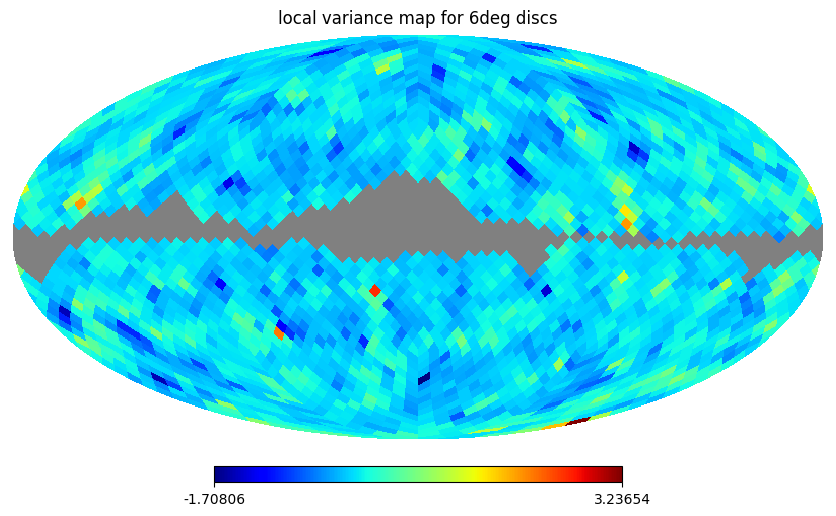

In [6]:
var_var = np.var(sim_measure, axis=0)
mean_var = np.mean(sim_measure, axis=0)
cmb_var = cmb_measure
hp.mollview((cmb_var - mean_var) / var_var,
            # min = -30,
            # max = 30,
            title = f"local variance map for {disc_size}deg discs",
            cmap = "jet")
# hp.mollview((cmb_measure**2 - mean_std**2), cmap="jet")

#### Dipole Amplitude

In [7]:
hp.fit_dipole((cmb_var - mean_var) / var_var)

(-0.016807938513175205, array([-0.07778609, -0.03621909, -0.02553133]))